In [23]:
import pandas as pd
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("dataset/label.csv", sep=',')
df = df.sample(frac=1).reset_index(drop=True)
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
display(df.head(10))

,image,emotion,emotion_encoded
0,78.jpg,Sad,6
1,95.jpg,Surprised,7
2,142.jpg,Sad,6
3,54.jpg,Sad,6
4,93.jpg,Neutral,5
5,146.jpg,Disgust,2
6,130.jpg,Disgust,2
7,143.jpg,Surprised,7
8,25.jpg,Contempt,1
9,22.jpg,Sad,6


In [3]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = 'dataset/images/'+str(image_name)
        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))
        return t_img, self.data.iloc[idx]['emotion_encoded'].item()

In [4]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(df)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/home/dev/anaconda3/envs/genai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dev/anaconda3/envs/genai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [6]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [7]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    h.remove()
    return my_embedding

In [8]:
xs = []
for t_img, label_encoder in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    dim = embdg.shape[1]
    seq_length = embdg.view(dim, -1).size(1)
    xs.append(embdg.squeeze().view(-1).detach().cpu().numpy())

  0%|          | 0/152 [00:00<?, ?it/s]

In [9]:
df['embeddings'] = xs

In [10]:
df

,image,emotion,emotion_encoded,embeddings
0,78.jpg,Sad,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20465331, 0.5732318, 0.0, 0.0, 0.0, 0.0, 0.6053039, 1.0968289, 0.8593943, 0.13590962, 0.0, 0.0, 0.0, 1.6814351, 1.4482077, 0.59091175, 0.0, 1.0658736, 1.001206, 1.1679735, 0.501837, 0.27876374, 0.0, 0.0, 0.0, 0.0, 0.27750313, 0.19609638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76087505, 0.0, 0.0, 0.0, 0.7468059, 0.6446557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5750086, 0.7100747, 0.0, 0.0, 0.0, 0.27127522, 0.45403096, 0.80439186, 1.1339345, 0.5553084, 0.25846773, 0.7820539, 0.73739594, 0.42922288, 0.27106217, 0.45528898, 0.25108716, 0.0, 2.07331, 1.713314, 0.57332665, 0.0, 0.34866086, 0.0, 0.0, 1.5226073, 2.0222123, 0.8453817, 0.0, 0.049124796, 0.0, 0.29808712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35939565, 1.3133955, 1.5918837, ...]"
1,95.jpg,Surprised,7,"[0.31730485, 0.83995813, 0.7158318, 0.2414785, 0.0, 0.0, 0.0, 0.75016683, 1.4563864, 0.7359056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41375703, 0.41635713, 0.48690137, 0.0, 0.0, 0.0, 0.0, 0.1444583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047026202, 1.4615594, 1.6638824, 1.6467048, 0.0, 0.0, 0.0, 0.15034756, 0.8507762, 2.2168257, 1.658175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5878498, 0.5947748, 0.0, 0.0, 0.0, 1.9533898, 1.401913, 0.5304503, 0.0, 0.0, 0.10311881, 0.5191684, 0.3226281, 0.7954366, 0.33177593, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28729585, 0.0, 0.0, 0.0, 0.0, 0.47628352, 1.7748774, 1.6716992, 0.0, 0.0, 0.0, 0.0, 1.8162644, 3.9953332, 3.6938, 0.3762932, 0.0, 0.0, 0.0, 2.0448184, 3.250391, 2.6376302, 0.0, 0.0, ...]"
2,142.jpg,Sad,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16687974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3830879, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38943654, 0.9217321, 0.20825396, 0.0, 0.0, 0.0, 0.0, 0.28471807, 1.0093898, 0.113214314, 0.0, 0.0, 0.0, 0.0044038147, 0.0, 0.19406812, 0.0, 0.0, 0.0, 0.7636992, 1.4548799, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58161026, 1.0512943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3504222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
3,54.jpg,Sad,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3453464, 0.40222862, 0.0, 0.0, 0.0, 0.0, 0.14513867, 1.8447119, 1.5203788, 0.0, 0.07731755, 0.0, 0.0, 2.07424, 3.9458966, 3.4679558, 0.0, 0.32101575, 0.6314997, 1.5686437, 3.4819105, 4.4519715, 3.7744098, 0.0, 0.0, 0.58307236, 1.7141411, 2.3104086, 3.0109596, 3.2265975, 0.0, 0.0, 2.3063066, 2.8975139, 3.1468241, 2.4734776, 2.2936542, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.028375965, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8407213, 0.0, 0.25513557, 0.0, 0.991929, 0.9028903, 1.4476998, 0.4121707, 0.0, 0.0, 0.0, 0.0664217, 0.0028786063, 0.3467121, 2.002017, 0.50059605, 0.0, 0.0, 0.0, 1.31606, 1.9978815, 0.9324186, 0.016478194, 0.084105276, 0.0014227437, 1.3372657, 2.3937457, 2.379616, 0.17214145, 0.0, 0.0, 0.0, 0.22888505, 0.5739267, 1.4906635, 0.06912243, 0.0, ...]"
4,93.jpg,Neutral,5,"[0.0, 0.0, 0.0, 0.0141810775, 0.0, 0.33538118, 0.41397122, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.248519, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7785043, 1.2644954, 1.3946606, 0.0, 0.0, 0.0, 0.0, 0.3899857, 1.3504995, 1.5105994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07259368, 0.0, 0.0, 0.0, 0.0, 0.12940386, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.258134, 0.6659234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.79027814, 1.1485547, 0.0, 0.0, 0.0, 0.0, 0.06699495, 1.3310118, 1.7046918, 0.0, 0.0, 0.0, 0.0, 1.6401448, 2.7062166, 2.216527, 0.0, 0.0, 0.0, 0.0, 1.1748049, 1.538406, 0.97122484, 0.28117332, 0.49858385, ...]"
...,...,...,...,...
147,87.jpg,Surprised,7,"[0.0, 0.6820264, 1.4399837, 1.5615702, 1.0194215, 0.31423625, 0.0, 0.0, 0.72560066, 2.5757, 3.5030727, 2.9436424, 1.6757338, 0.21350728, 0.0, 2.3727007, 5.615593,

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['embeddings'], df['emotion_encoded'], test_size=0.2)

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(np.stack(X_train), np.stack(y_train))

RandomForestClassifier(n_estimators=200, random_state=42)

In [20]:
y_pred_test = rf_classifier.predict(np.stack(X_test))
accuracy_score(y_test, y_pred_test)

0.7419354838709677

In [38]:
ss = np.stack(X_test)
print(type(ss[0]))

<class 'numpy.ndarray'>


Predicted: happy
Actual: happy


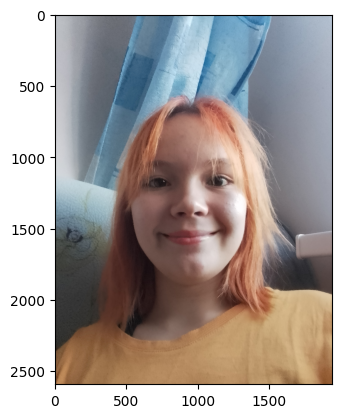

In [53]:
%matplotlib inline
test_id = "124.jpg"
img = np.asarray(Image.open('dataset/images/{}'.format(test_id)))
plt.imshow(img)
img_embedding = df[df['image']==test_id]['embeddings'].to_numpy()
predict = rf_classifier.predict(np.stack(img_embedding))
actual = df[df['image']==test_id]['emotion_encoded'].to_numpy()
id2label = {4:"happy",6:"sad",7:"suprised",5:"neutral",1:"contempt",2:"disgust",3:"fear"}


print("Predicted: {}".format(id2label[predict[0]]))
print("Actual: {}".format(id2label[actual[0]]))